# Анализ данных служб такси - Вариант 25

Практическая работа: консолидация и аналитическая обработка данных служб такси с использованием Docker Compose, Jupyter Lab и PostgreSQL.

## Цель
Рассчитать чистую прибыль для каждой службы такси на выбранном периоде и дать визуализацию и суммарный отчёт.

## Источники данных
- **taxi_companies.csv** - данные о службах такси (taxi_company_id, company_name)
- **trips.xlsx** - агрегированные данные о поездках (taxi_company_id, trips_count, avg_trip_price, period_date)
- **expenses.json** - расходы по компаниям (taxi_company_id, fuel_cost, maintenance_cost, period_date)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
import warnings
warnings.filterwarnings('ignore')

# Настройка стиля графиков
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✓ Библиотеки загружены")


✓ Библиотеки загружены


## 1. Загрузка данных из различных источников


In [10]:
# Загрузка данных об авиакомпаниях (CSV)
df_taxi_companies = pd.read_csv('data/taxi_companies.csv')
print("Данные о такси-компаниях (CSV):")
print(f"Форма данных: {df_taxi_companies.shape}")
print(df_taxi_companies.head())
print("\n" + "="*50 + "\n")


Данные о такси-компаниях (CSV):
Форма данных: (5, 4)
  company_code     company_name country  founded_year
0        TX001     Такси Быстро  Россия          2008
1        TX002  Городской Такси  Россия          2012
2        TX003     Эконом Такси  Россия          2015
3        TX004     Бизнес Такси  Россия          2010
4        TX005   Ночной Маршрут  Россия          2018




In [11]:
# Загрузка данных о рейсах (Excel)
df_trips = pd.read_excel('data/trips.xlsx')
print("Данные о поездках (Excel):")
print(f"Форма данных: {df_trips.shape}")
print(df_trips.head())
print("\n" + "="*50 + "\n")


Данные о поездках (Excel):
Форма данных: (30, 4)
  taxi_company_code period_date  trips_count  avg_trip_price
0             TX001  2025-11-01         5738          344.73
1             TX001  2025-10-01         6574          557.54
2             TX001  2025-09-01         2328          381.40
3             TX001  2025-08-01         1339         1079.71
4             TX001  2025-07-01         7808          908.98




In [12]:
# Загрузка данных о билетах (JSON)
with open('data/expenses.json', 'r', encoding='utf-8') as f:
    expenses_data = json.load(f)

df_expenses = pd.DataFrame(expenses_data)
print("Данные о расходах (JSON):")
print(f"Форма данных: {df_expenses.shape}")
print(df_expenses.head())
print("\n" + "="*50 + "\n")


Данные о расходах (JSON):
Форма данных: (30, 4)
  taxi_company_code period_date  fuel_cost  maintenance_cost
0             TX001  2025-11-01  170701.00          70035.25
1             TX001  2025-10-01  544979.11          85669.79
2             TX001  2025-09-01  359126.68          57711.27
3             TX001  2025-08-01  286884.48         188597.83
4             TX001  2025-07-01  553624.77         129643.58




## 2. Консолидация данных и расчет выручки


In [15]:
# Объединение всех данных
# Шаг 1: Объединение поездок с расходами
df_trips_expenses = pd.merge(df_trips, df_expenses, on=['taxi_company_code', 'period_date'], how='inner')

# Шаг 2: Переименовываем столбец в df_taxi_companies для согласования ключей
df_taxi_companies_renamed = df_taxi_companies.rename(columns={'company_code': 'taxi_company_code'})

# Теперь объединяем с переименованной таблицей
df_consolidated = pd.merge(df_trips_expenses, df_taxi_companies_renamed, on='taxi_company_code', how='inner')

# Расчет выручки за каждый период для каждой компании
df_consolidated['revenue'] = df_consolidated['trips_count'] * df_consolidated['avg_trip_price']

# Расчет прибыли (выручка минус расходы)
df_consolidated['profit'] = df_consolidated['revenue'] - (df_consolidated['fuel_cost'] + df_consolidated['maintenance_cost'])

print("Консолидированные данные:")
print(f"Форма данных: {df_consolidated.shape}")
print(df_consolidated[['company_name', 'period_date', 'trips_count', 'avg_trip_price', 'revenue', 'profit']].head())

# Расчет общей прибыли для каждой такси-компании
company_profit = df_consolidated.groupby(['taxi_company_code', 'company_name']).agg({
    'profit': 'sum',
    'revenue': 'sum',
    'trips_count': 'sum',
    'avg_trip_price': 'mean',
    'fuel_cost': 'sum',
    'maintenance_cost': 'sum'
}).round(2)

company_profit.columns = ['total_profit', 'total_revenue', 'total_trips', 'avg_price', 'total_fuel_cost', 'total_maintenance_cost']
company_profit = company_profit.sort_values('total_profit', ascending=False)

print("\n" + "="*60)
print("ОБЩАЯ ПРИБЫЛЬ ПО ТАКСИ-КОМПАНИЯМ")
print("="*60)
print(company_profit)

Консолидированные данные:
Форма данных: (30, 11)
   company_name period_date  trips_count  avg_trip_price     revenue  \
0  Такси Быстро  2025-11-01         5738          344.73  1978060.74   
1  Такси Быстро  2025-10-01         6574          557.54  3665267.96   
2  Такси Быстро  2025-09-01         2328          381.40   887899.20   
3  Такси Быстро  2025-08-01         1339         1079.71  1445731.69   
4  Такси Быстро  2025-07-01         7808          908.98  7097315.84   

       profit  
0  1737324.49  
1  3034619.06  
2   471061.25  
3   970249.38  
4  6414047.49  

ОБЩАЯ ПРИБЫЛЬ ПО ТАКСИ-КОМПАНИЯМ
                                   total_profit  total_revenue  total_trips  \
taxi_company_code company_name                                                
TX003             Эконом Такси      25188437.21    28818806.01        30854   
TX005             Ночной Маршрут    20117116.21    23591267.15        31592   
TX001             Такси Быстро      16251006.30    19069019.93        29

## 3. Визуализация результатов


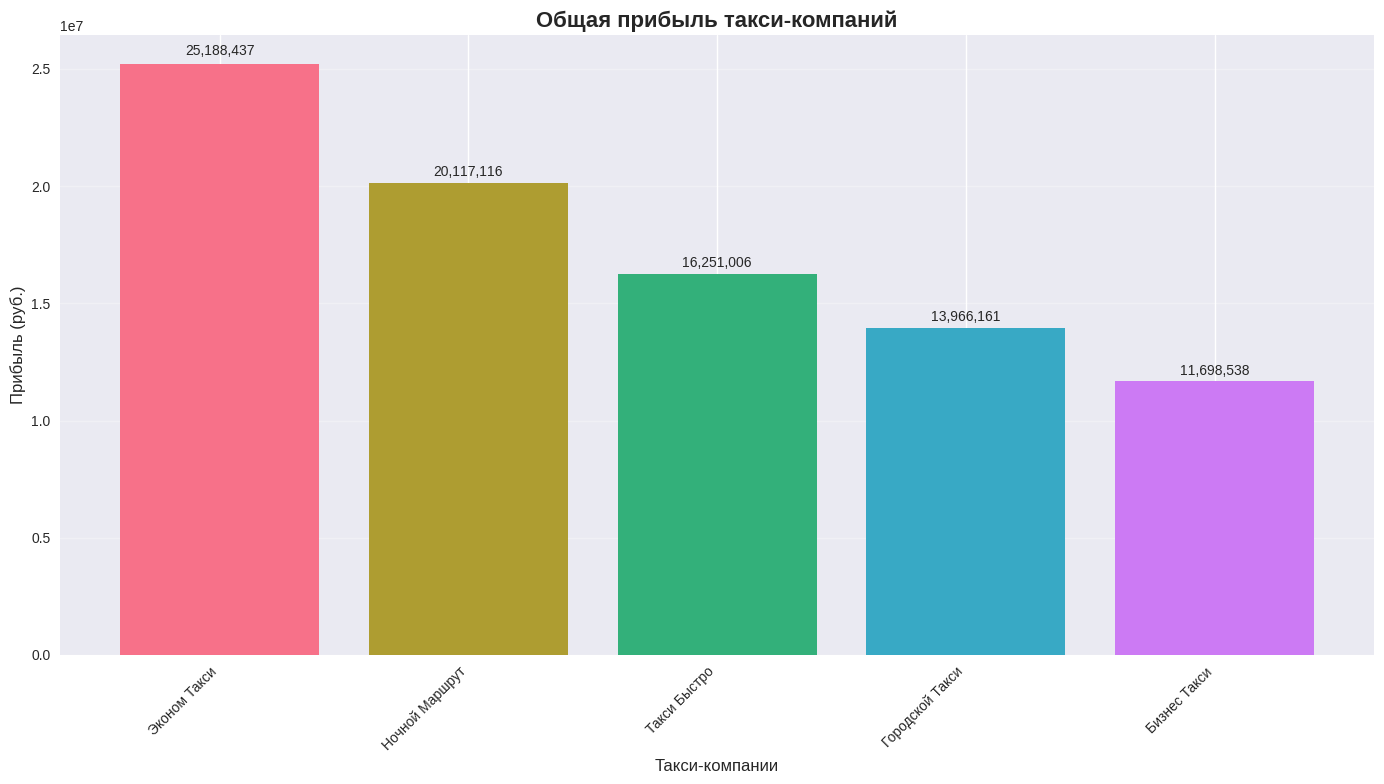

In [16]:
# График 1: Общая прибыль такси-компаний
plt.figure(figsize=(14, 8))
bars = plt.bar(range(len(company_profit)), company_profit['total_profit'], color=sns.color_palette("husl", len(company_profit)))
plt.title('Общая прибыль такси-компаний', fontsize=16, fontweight='bold')
plt.xlabel('Такси-компании', fontsize=12)
plt.ylabel('Прибыль (руб.)', fontsize=12)
plt.xticks(range(len(company_profit)), company_profit.index.get_level_values('company_name'), rotation=45, ha='right')

# Добавление значений на столбцы
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01, f'{height:,.0f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

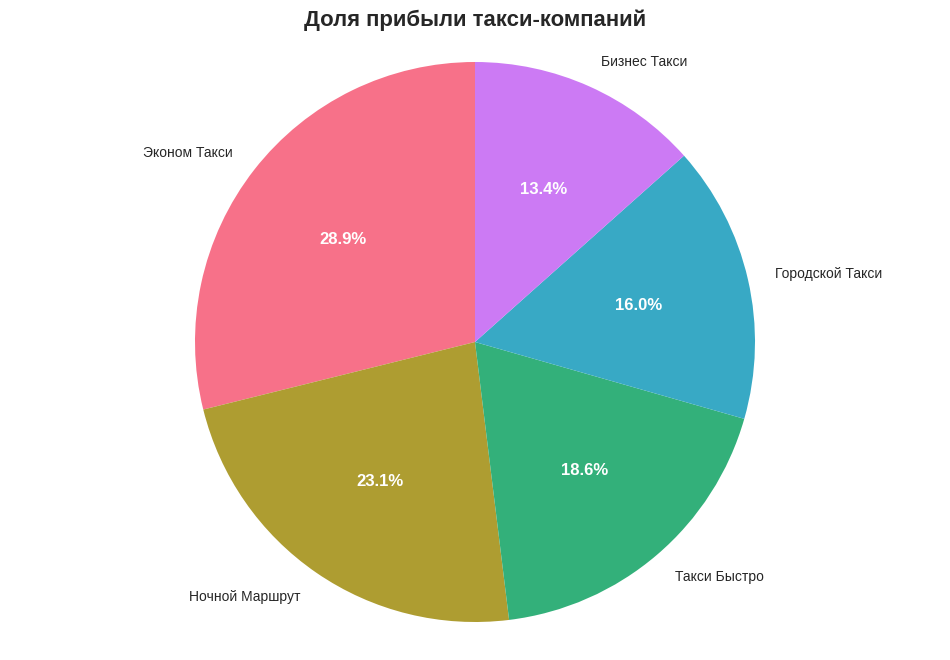

In [17]:
# График 2: Круговая диаграмма доли прибыли
plt.figure(figsize=(12, 8))
colors = sns.color_palette("husl", len(company_profit))
wedges, texts, autotexts = plt.pie(
    company_profit['total_profit'],
    labels=company_profit.index.get_level_values('company_name'),
    autopct='%1.1f%%',
    colors=colors,
    startangle=90
)
plt.title('Доля прибыли такси-компаний', fontsize=16, fontweight='bold')

# Улучшение читаемости
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.axis('equal')
plt.show()

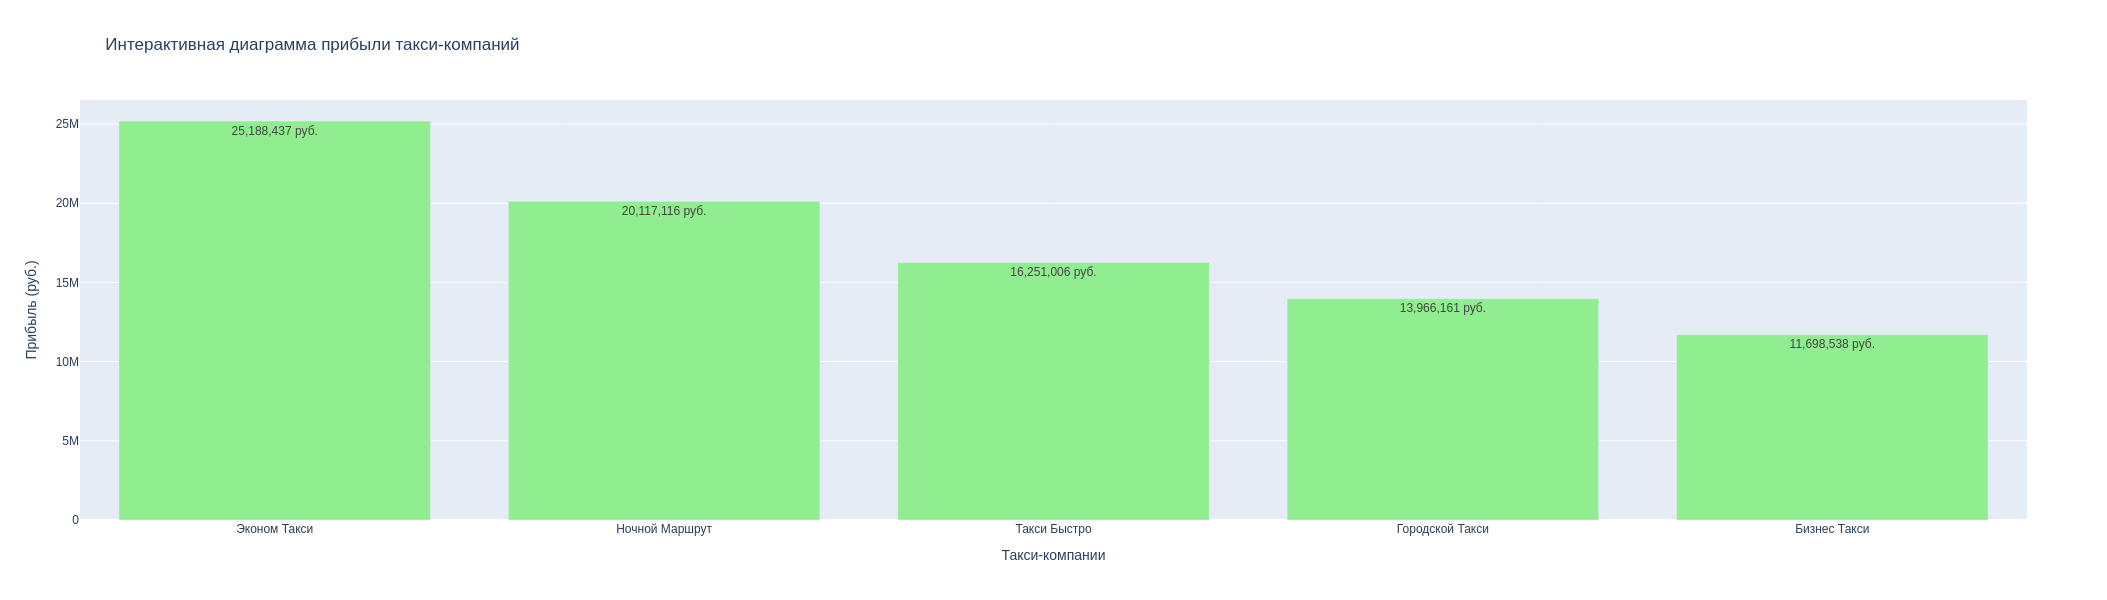

In [18]:
# График 3: Интерактивная визуализация с Plotly
fig = go.Figure()

# Добавляем столбцы прибыли
fig.add_trace(go.Bar(
    x=company_profit.index.get_level_values('company_name'),
    y=company_profit['total_profit'],
    name='Прибыль',
    marker_color='lightgreen',
    text=[f'{x:,.0f} руб.' for x in company_profit['total_profit']],
    textposition='auto'
))

fig.update_layout(
    title='Интерактивная диаграмма прибыли такси-компаний',
    xaxis_title='Такси-компании',
    yaxis_title='Прибыль (руб.)',
    showlegend=False,
    height=600
)

fig.show()

## 4. Выводы и сохранение результатов


In [19]:
# Формирование выводов и сохранение результатов
print("ОСНОВНЫЕ ВЫВОДЫ АНАЛИЗА")
print("=" * 50)

top_company = company_profit.index[0][1]
top_profit = company_profit.iloc[0]['total_profit']
total_market_profit = company_profit['total_profit'].sum()
market_share = (top_profit / total_market_profit) * 100

print(f"1. Лидер рынка: {top_company}")
print(f" - Прибыль: {top_profit:,.0f} руб.")
print(f" - Доля рынка: {market_share:.1f}%")

print(f"\n2. Общая прибыль рынка: {total_market_profit:,.0f} руб.")
print(f"3. Количество такси-компаний: {len(company_profit)}")
print(f"4. Средняя прибыль на компанию: {company_profit['total_profit'].mean():,.0f} руб.")

# Топ-3 такси-компании
print("\n5. ТОП-3 такси-компании по прибыли:")
for i, (idx, row) in enumerate(company_profit.head(3).iterrows(), 1):
    company_name = idx[1]
    profit = row['total_profit']
    trips = row['total_trips']
    print(f" {i}. {company_name}: {profit:,.0f} руб. ({trips} поездок)")

# Сохранение результатов
df_consolidated.to_csv('data/consolidated_taxi_data.csv', index=False)
company_profit.to_csv('data/taxi_profit_summary.csv')

print("\n" + "=" * 50)
print("✓ Результаты сохранены в папке 'data/'")
print("✓ Анализ завершен успешно!")

ОСНОВНЫЕ ВЫВОДЫ АНАЛИЗА
1. Лидер рынка: Эконом Такси
 - Прибыль: 25,188,437 руб.
 - Доля рынка: 28.9%

2. Общая прибыль рынка: 87,221,259 руб.
3. Количество такси-компаний: 5
4. Средняя прибыль на компанию: 17,444,252 руб.

5. ТОП-3 такси-компании по прибыли:
 1. Эконом Такси: 25,188,437 руб. (30854.0 поездок)
 2. Ночной Маршрут: 20,117,116 руб. (31592.0 поездок)
 3. Такси Быстро: 16,251,006 руб. (29124.0 поездок)

✓ Результаты сохранены в папке 'data/'
✓ Анализ завершен успешно!
